# Import .npz Database containing 5SS mechanisms and cplr paths

In [1]:
import numpy as np

db = np.load('norm_database5SS.npz')
db.files
cplr=db['cplrData']
mech=db['mechData']

In [2]:
# Plotting Functions

#%matplotlib inline
%matplotlib notebook
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from scipy import interpolate


def plotPath(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline, yline, zline, color)
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])

def plotXYZ(center, RotMat, ax):
    C=np.vstack((center,center,center))
    R=RotMat
    r=(1,0,0)
    g=(0,1,0)
    b=(0,0,1)
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b))

# Find Path Descriptors using Z space of VAE

VAE are good at:
- **dimensionality reduction** for data visualization
- **data denoising**

Dimensions of Input space= n x 100 x 3

Dimensions of Latent space (z-space)= 2

In [3]:
x= cplr

# Split data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, _, _ = train_test_split(x, x, test_size=0.2)

In [4]:
from keras.layers import Input, Dense, Flatten, Reshape, SeparableConv1D, concatenate
from keras.models import Model
from keras.layers import LeakyReLU
from keras import regularizers

def testAutoEncoder(autoencoder, encoder, x_train, x_test):
    # TRAINING PHASE
    epochs=50
    autoencoder_train=autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=64, 
                                      shuffle=True, validation_data=(x_test, x_test), verbose=0)
    loss = autoencoder_train.history['loss']
    val_loss = autoencoder_train.history['val_loss']
    print('Final Training loss: '+str(np.round_(loss[-1],decimals=4)))
    print('Final Validation loss: '+str(np.round_(val_loss[-1],decimals=4)))
    epochsRange = range(epochs)
    plt.figure()
    plt.plot(epochsRange, loss, 'r', label='Training loss')
    plt.plot(epochsRange, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    # VISUALIZING RESULTS
    predicted_curve = autoencoder.predict(x_test)
    z_param = encoder.predict(x_test)
    #print(z_param)
    #print(predicted_curve)

    n = 20  # how many digits we will display
    plt.figure(figsize=(3*n, 3))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1, projection='3d')

        # Fit cubic B-spline to the predicted points
        xp=predicted_curve[i,:,0]
        yp=predicted_curve[i,:,1]
        zp=predicted_curve[i,:,2]
        tck, u =interpolate.splprep([xp,yp,zp],s=1)
        num_pts=100
        u_fine = np.linspace(0,1,num_pts)
        x_100, y_100, z_100 = interpolate.splev(u_fine, tck)
        Path_100 = np.vstack(([x_100],[y_100],[z_100])).T

        # display reconstruction
        plotPath(Path_100, ax, 2,'r' )
        # display original
        plotPath(x_test[i], ax, 2)

    plt.tight_layout()
    plt.show()

Using TensorFlow backend.


## Autoencoder Z=2





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 3)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 22        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                30        
______

<IPython.core.display.Javascript object>


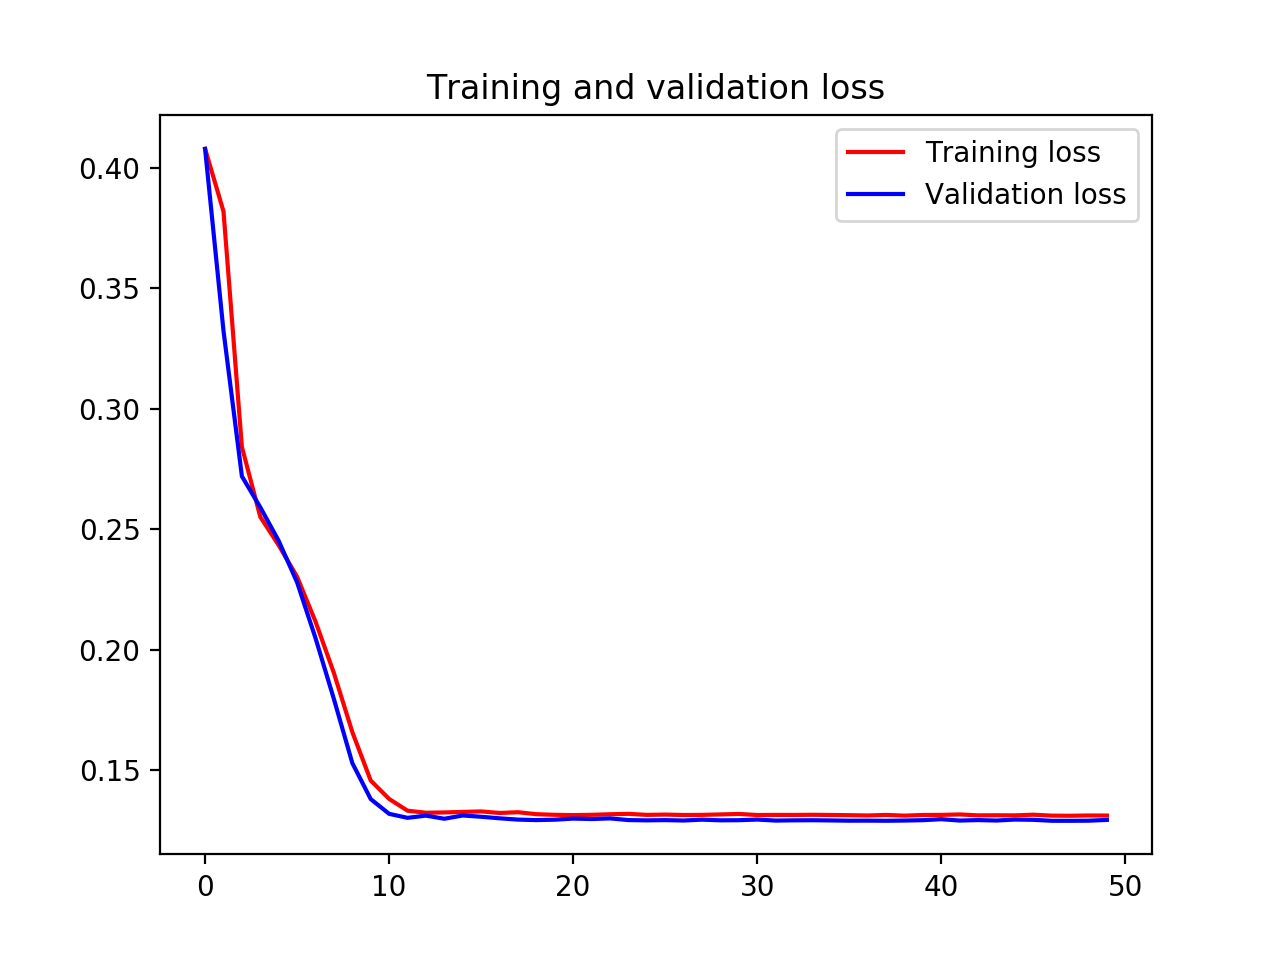

<IPython.core.display.Javascript object>


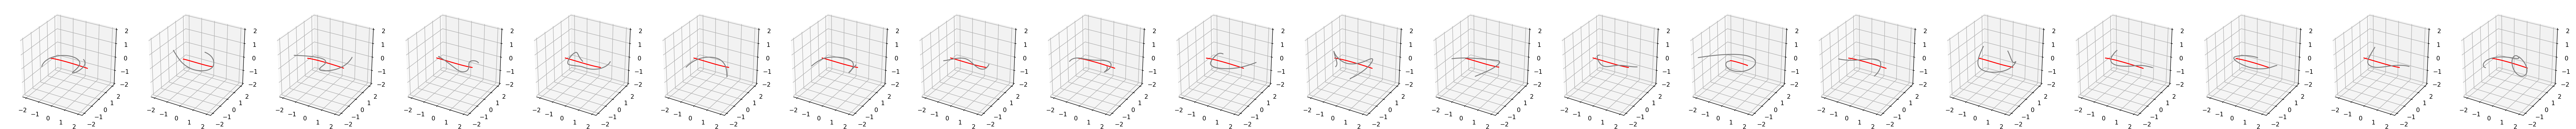

In [5]:
def autoEncoderZ2():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    x=Dense(10, activation='relu')(x)
    encoded=Dense(2, activation='relu')(x)
    #encoded=Dense(10, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(10, activation='relu')(encoded)
    x=Dense(30, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    autoencoder.summary()
    
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

autoencoderZ2, encoderZ2=autoEncoderZ2()
testAutoEncoder(autoencoderZ2, encoderZ2, x_train, x_test)

## Autoencoder Z=3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 3)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_10 (Dense)             (None, 30)                3030      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 33        
_________________________________________________________________
dense_13 (Dense)             (None, 10)                40        
__________

<IPython.core.display.Javascript object>


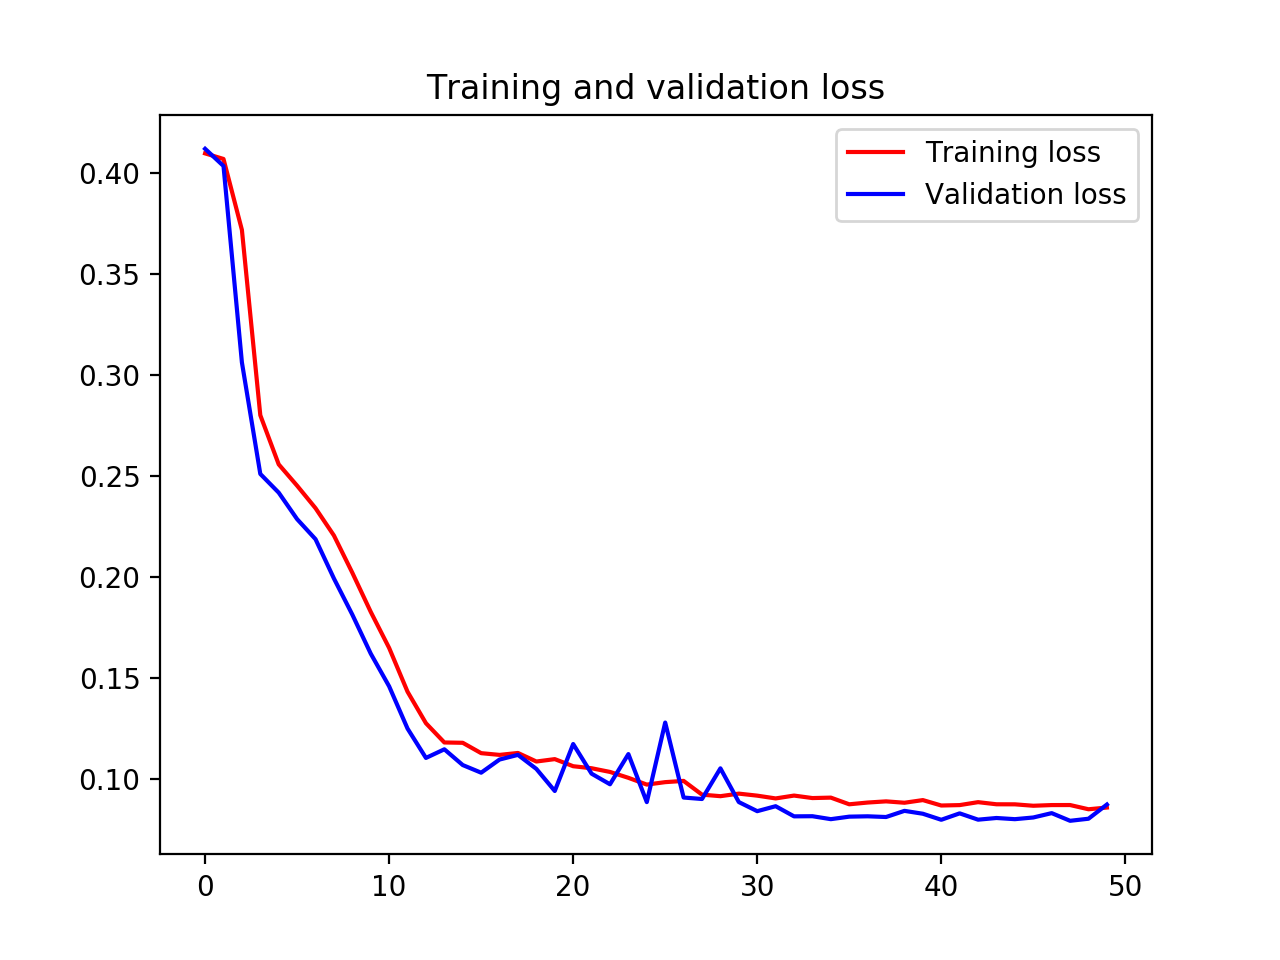

<IPython.core.display.Javascript object>


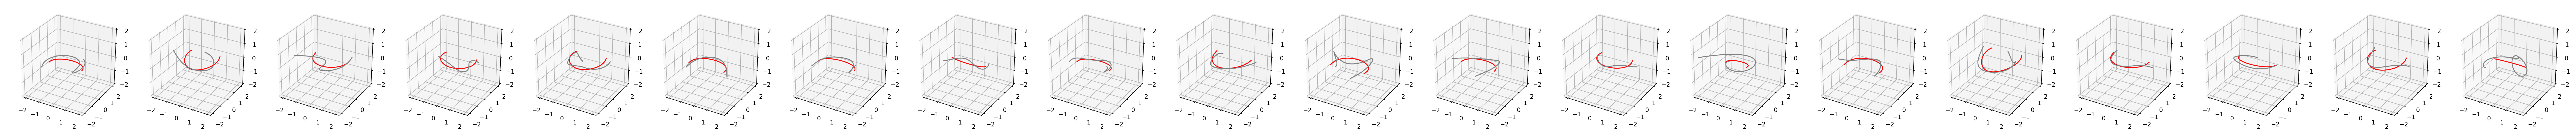

In [6]:
def autoEncoderZ3():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    x=Dense(10, activation='relu')(x)
    encoded=Dense(3, activation='relu')(x)
    #encoded=Dense(10, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(10, activation='relu')(encoded)
    x=Dense(30, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    autoencoder.summary()
    
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

autoencoderZ3, encoderZ3=autoEncoderZ3()
testAutoEncoder(autoencoderZ3, encoderZ3, x_train, x_test)

## Autoencoder Z=10

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 3)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_18 (Dense)             (None, 30)                3030      
_________________________________________________________________
dense_19 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_20 (Dense)             (None, 30)                330       
_________________________________________________________________
dense_21 (Dense)             (None, 100)               3100      
__________

<IPython.core.display.Javascript object>


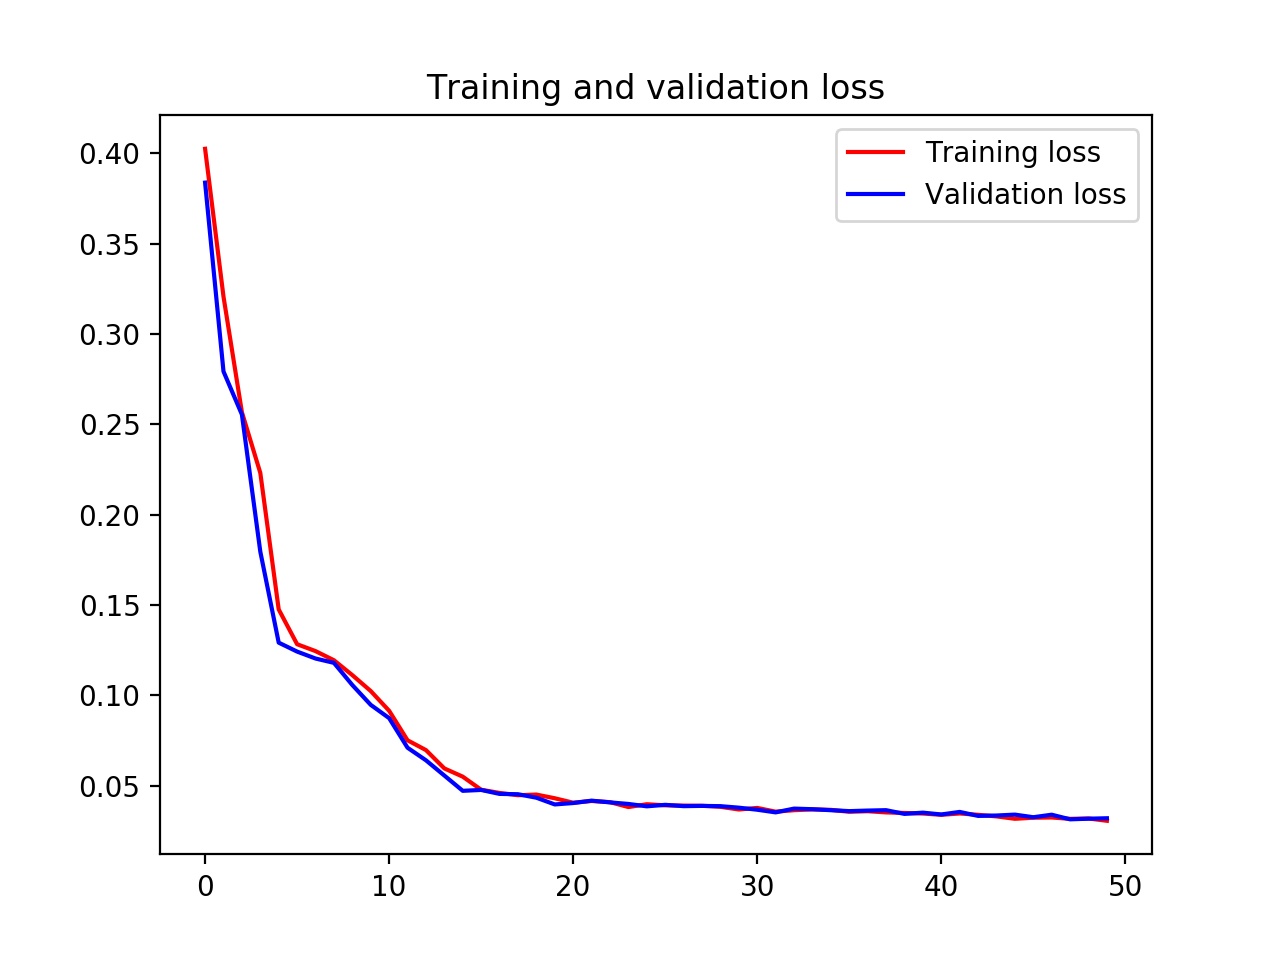

<IPython.core.display.Javascript object>


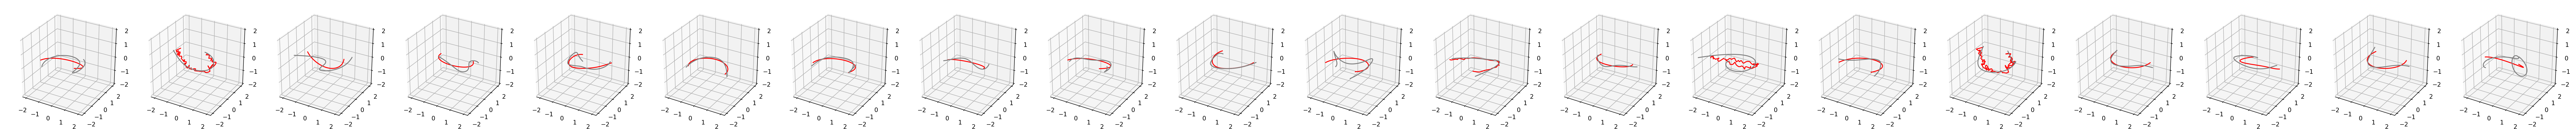

In [7]:
def autoEncoderZ10():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    encoded=Dense(10, activation='relu')(x)
    #encoded=Dense(10, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(30, activation='relu')(encoded)
    x=Dense(100, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    autoencoder.summary()
    
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

autoencoderZ10, encoderZ10=autoEncoderZ10()
testAutoEncoder(autoencoderZ10, encoderZ10, x_train, x_test)

## Autoencoder Z=50

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 3)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_24 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_25 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_26 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_27 (Dense)             (None, 200)               20200     
__________

<IPython.core.display.Javascript object>


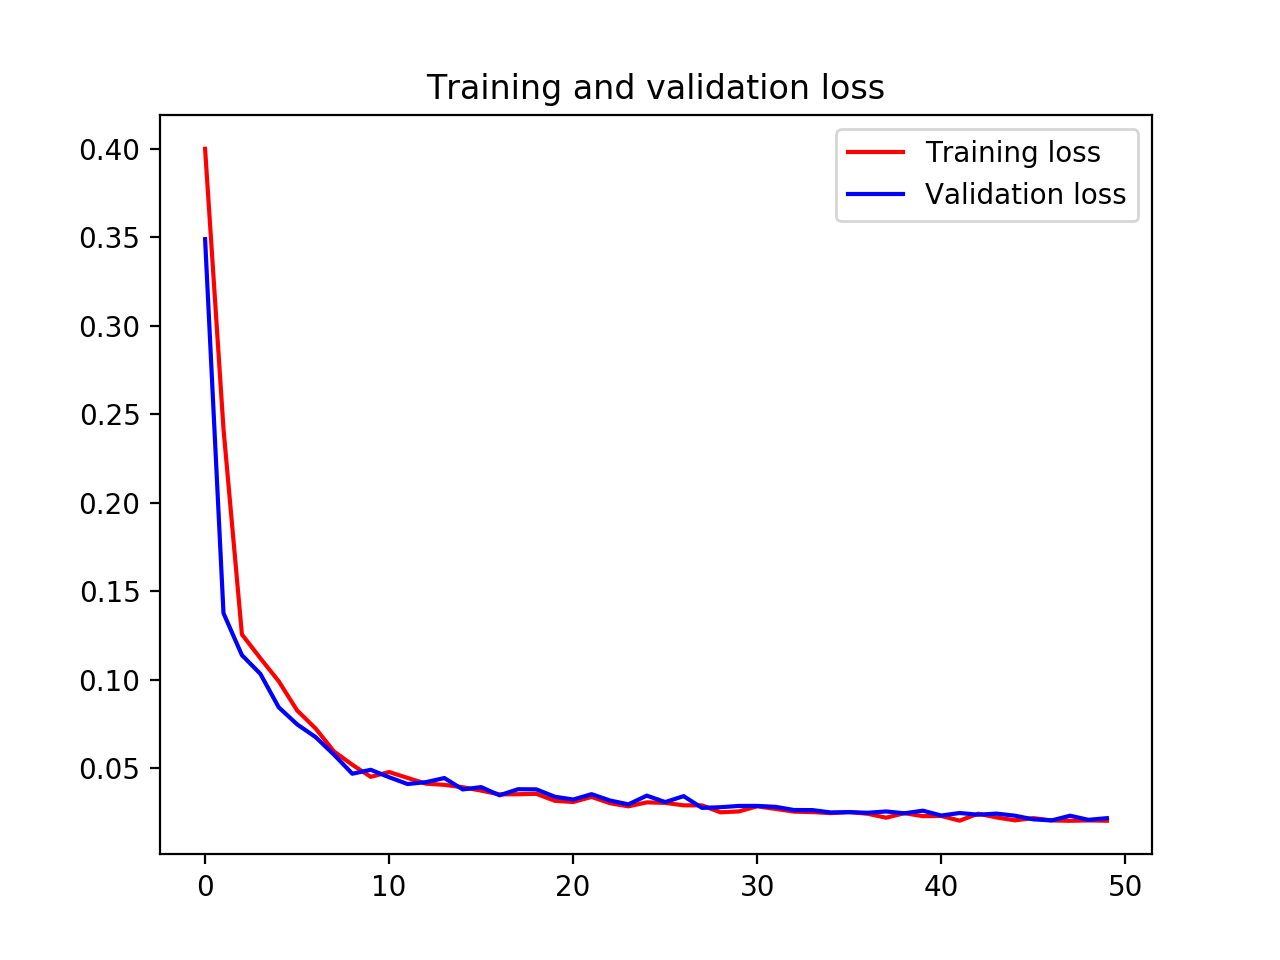

<IPython.core.display.Javascript object>


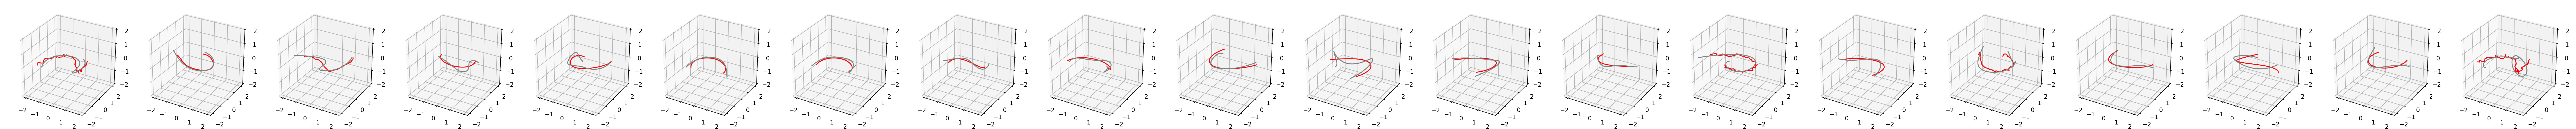

In [8]:
def autoEncoderZ50():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(200, activation='relu')(x)
    x=Dense(100, activation='relu')(x)
    encoded=Dense(50, activation='relu')(x)
    #encoded=Dense(10, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(100, activation='relu')(encoded)
    x=Dense(200, activation='relu')(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    autoencoder.summary()
    
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

autoencoderZ50, encoderZ50=autoEncoderZ50()
testAutoEncoder(autoencoderZ50, encoderZ50, x_train, x_test)

## AutoEncoder Z=300

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100, 3)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_30 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_31 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_32 (Dense)             (None, 300)               90300     
_________________________________________________________________
reshape_5 (Reshape)          (None, 100, 3)            0         
Total para

<IPython.core.display.Javascript object>


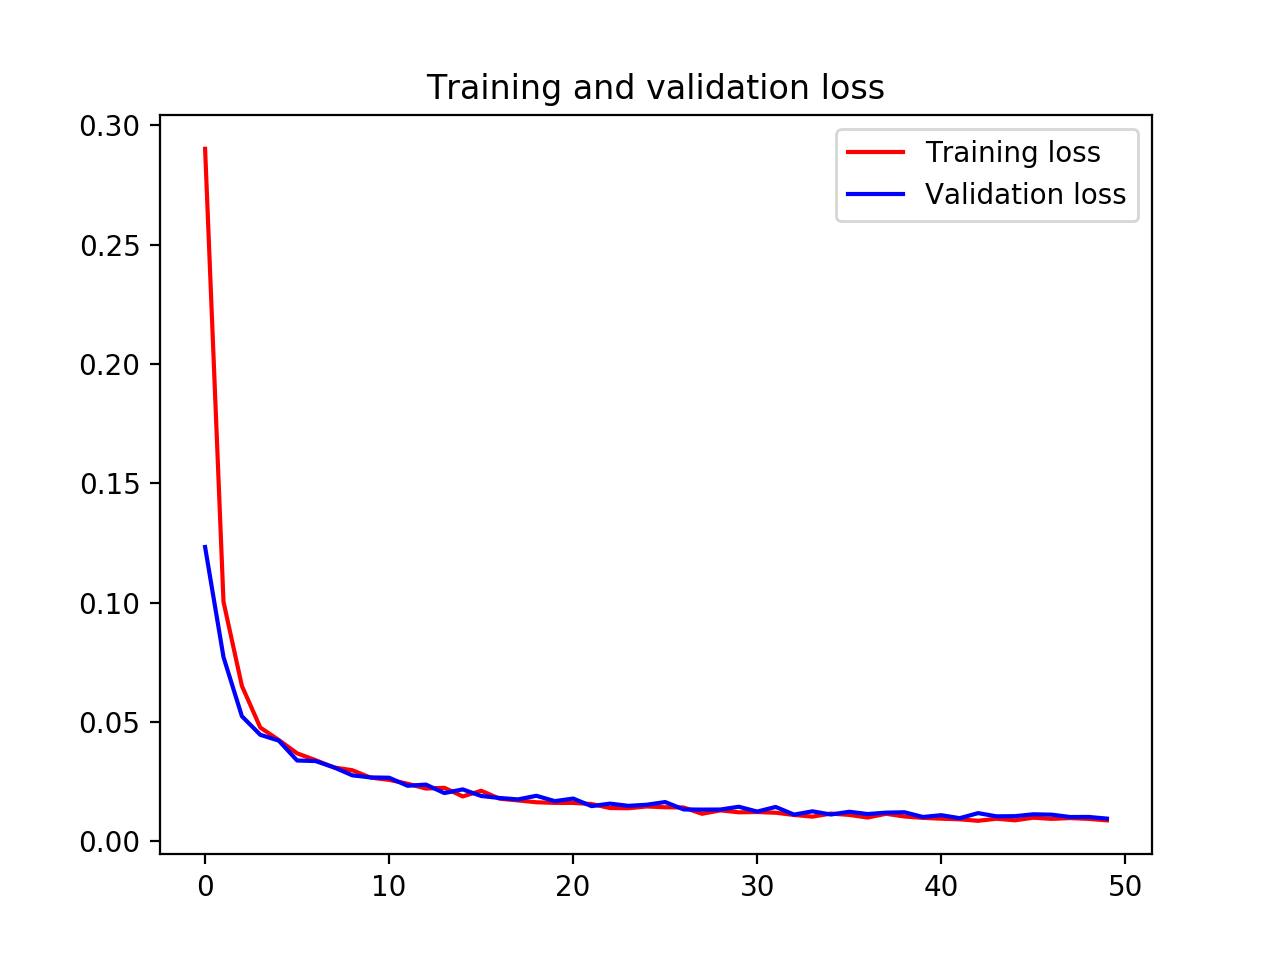

<IPython.core.display.Javascript object>


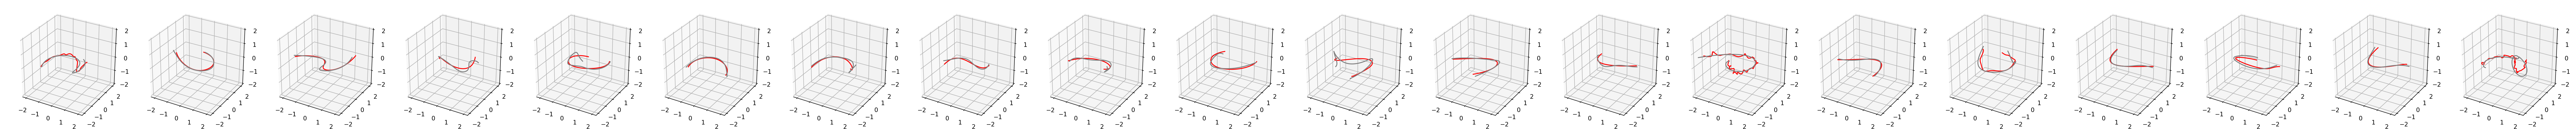

In [9]:
def autoEncoderZ300():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(300, activation='relu')(x)
    encoded=Dense(300, activation='relu')(x)
    #encoded=Dense(10, activation='relu',activity_regularizer=regularizers.l1(10e-5))(x)

    # Decoding
    x=Dense(300, activation='relu')(encoded)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    autoencoder.summary()
    
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

autoencoderZ300, encoderZ300=autoEncoderZ300()
testAutoEncoder(autoencoderZ300, encoderZ300, x_train, x_test)

## AutoEncoder Z=10 with LeakyRELU activation

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100, 3)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               30100     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 30)                3030      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 30)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 10)                310       
__________

<IPython.core.display.Javascript object>


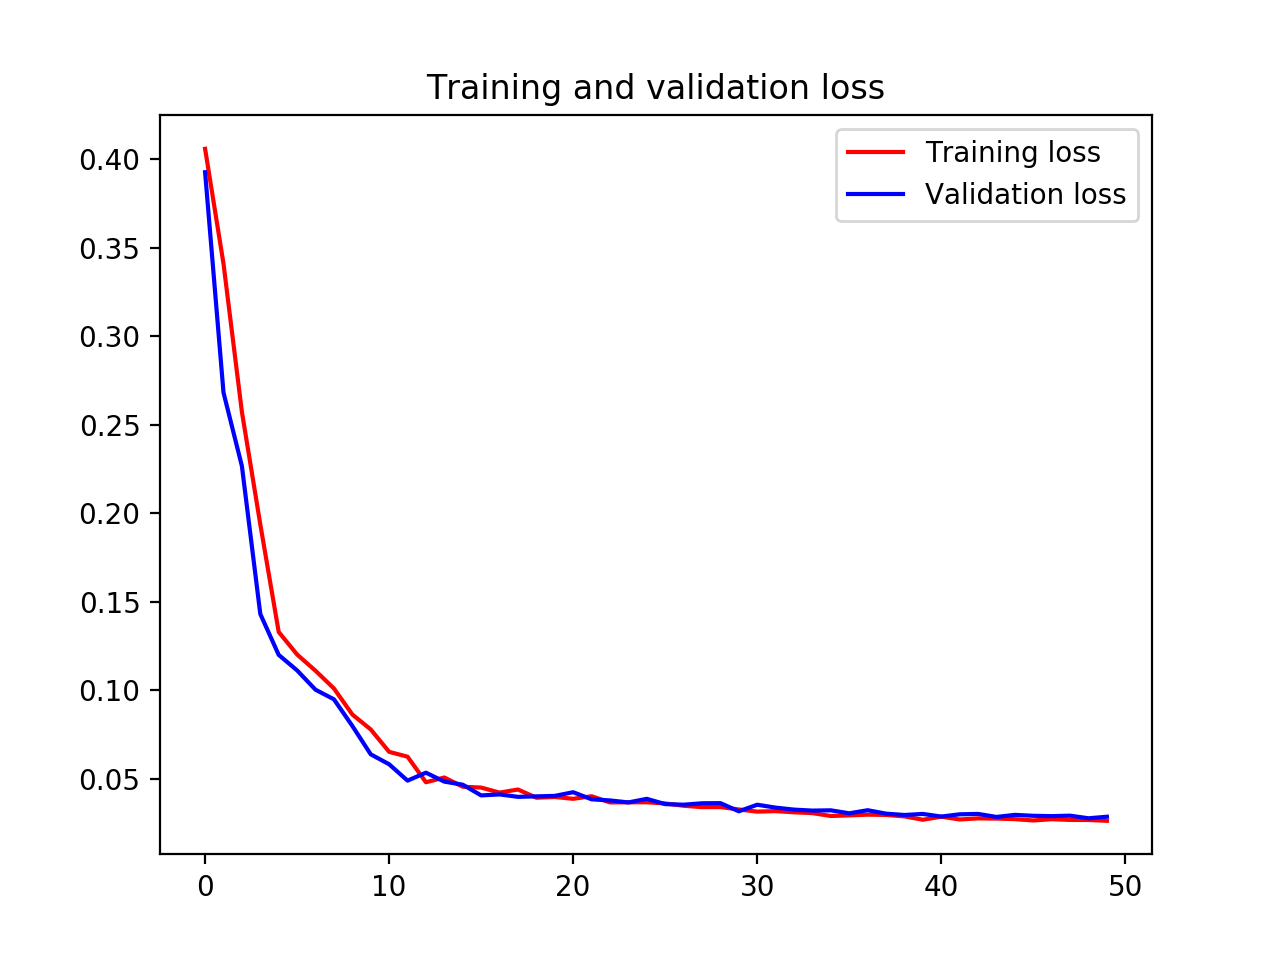

<IPython.core.display.Javascript object>


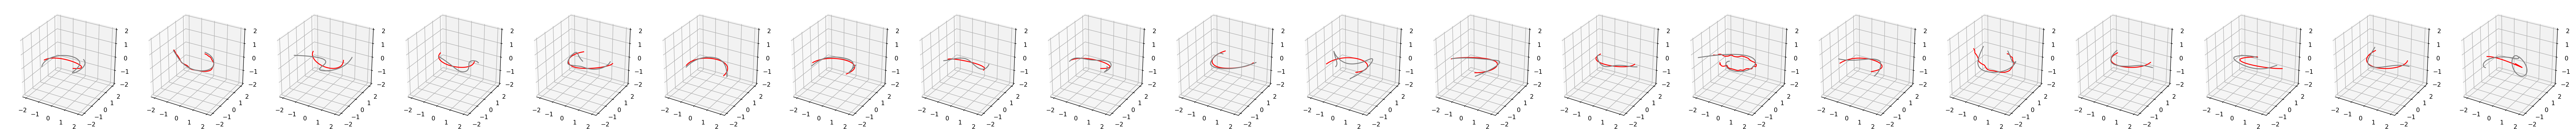

In [10]:
def autoEncoderleakyZ10():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x=Flatten()(inp_curve)
    x=Dense(100)(x)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(30)(x)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(10)(x)
    #x=Dense(10,activity_regularizer=regularizers.l1(10e-5))(x)
    encoded=LeakyReLU(alpha=0.01)(x)

    # Decoding
    x=Dense(30)(encoded)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(100)(x)
    x=LeakyReLU(alpha=0.01)(x)
    x=Dense(300)(x)
    decoded=Reshape((100, 3))(x)

    autoencoder = Model(inp_curve, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    autoencoder.summary()
    
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

autoencoderZ10L, encoderZ10L=autoEncoderleakyZ10()
testAutoEncoder(autoencoderZ10L, encoderZ10L, x_train, x_test)

## Convolution (Normal) AutoEncoder Z=10

## Convolution (Spatial Separable) AutoEncoder Z=10


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 100, 3)       0                                            
__________________________________________________________________________________________________
separable_conv1d_1 (SeparableCo (None, 100, 4)       31          input_7[0][0]                    
__________________________________________________________________________________________________
separable_conv1d_2 (SeparableCo (None, 100, 4)       76          input_7[0][0]                    
__________________________________________________________________________________________________
separable_conv1d_3 (SeparableCo (None, 100, 4)       166         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooli

<IPython.core.display.Javascript object>


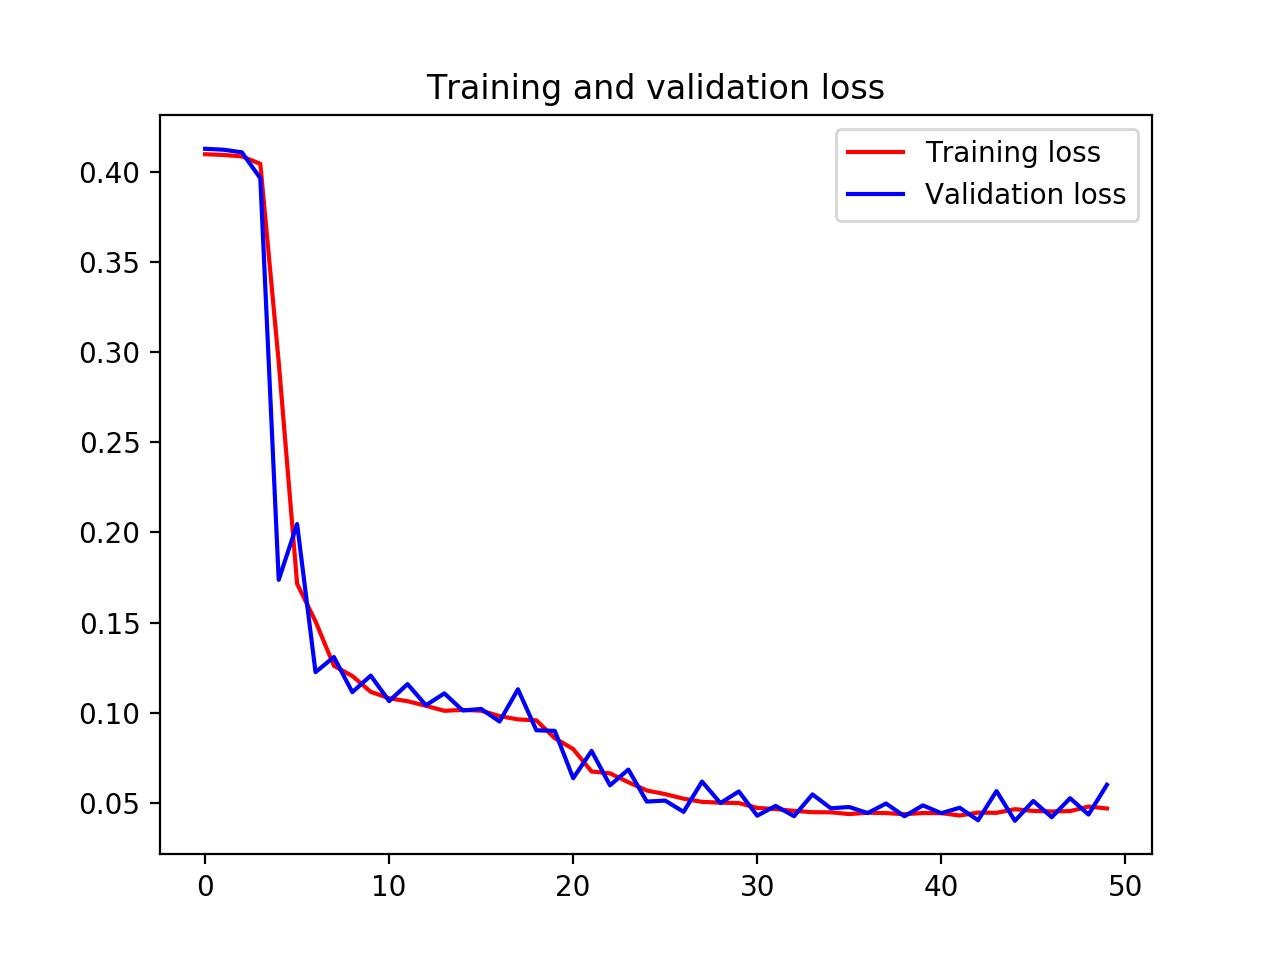

<IPython.core.display.Javascript object>


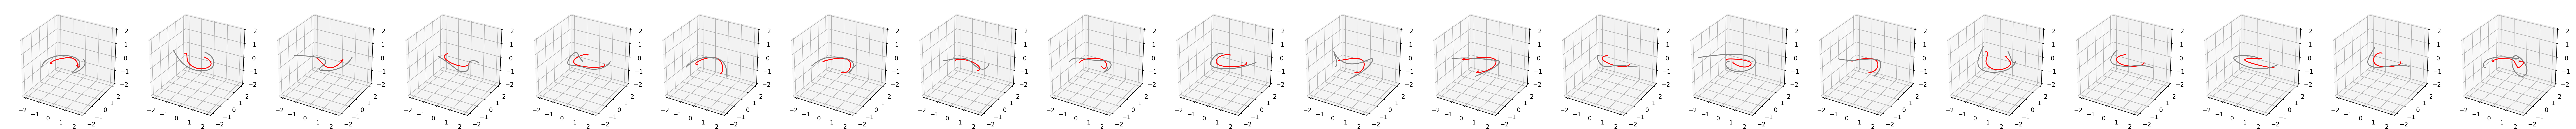

In [11]:
from keras.layers import Lambda, Add, MaxPooling1D, UpSampling1D

def autoEncoderCov1DZ10():
    inp_curve=Input(shape=(100,3,))

    # Encoding
    x1=SeparableConv1D(4,5,padding='same')(inp_curve)
    x1=MaxPooling1D(2)(x1)
    x1=Flatten()(x1)
    x2=SeparableConv1D(4,20,padding='same')(inp_curve)
    x2=MaxPooling1D(2)(x2)
    x2=Flatten()(x2)
    x3=SeparableConv1D(4,50,padding='same')(inp_curve)
    x3=MaxPooling1D(2)(x3)
    x3=Flatten()(x3)
    x=concatenate([x1,x2,x3], axis=1)
    x=Dense(100, activation='relu')(x)
    x=Dense(30, activation='relu')(x)
    encoded=Dense(10, activation='relu')(x)

    # Decoding
    x=Dense(30, activation='relu')(encoded)
    x=Dense(100, activation='relu')(x)
    x=Dense(600, activation='relu')(x)
    x1=Lambda(lambda x: x[:,0:50*4])(x)
    x1=UpSampling1D(2)(x1)
    x1=Reshape((100, 4))(x1)
    x1=SeparableConv1D(4,5,padding='same')(x1)
    x2=Lambda(lambda x: x[:,50*4:2*50*4])(x)
    x2=UpSampling1D(2)(x2)
    x2=Reshape((100, 4))(x2)
    x2=SeparableConv1D(4,5,padding='same')(x2)
    x3=Lambda(lambda x: x[:,2*50*4:3*50*4])(x)
    x3=UpSampling1D(2)(x3)
    x3=Reshape((100, 4))(x3)
    x3=SeparableConv1D(4,5,padding='same')(x3)
    x=Add()([x1, x2, x3])
    decoded=SeparableConv1D(3,5,padding='same')(x)

    autoencoder = Model(inp_curve, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    autoencoder.summary()
    
    encoder = Model(inp_curve, encoded)
    
    return autoencoder, encoder

autoencoderZ10C1D, encoderZ10C1D=autoEncoderCov1DZ10()
testAutoEncoder(autoencoderZ10C1D, encoderZ10C1D, x_train, x_test)

## Convolution (with FFT) AutoEncoder Z=10

## Variational Autoencoder Z=10

# Perform Hierarchical Clustering (K-Mean)(also try Dendrogram)

<IPython.core.display.Javascript object>


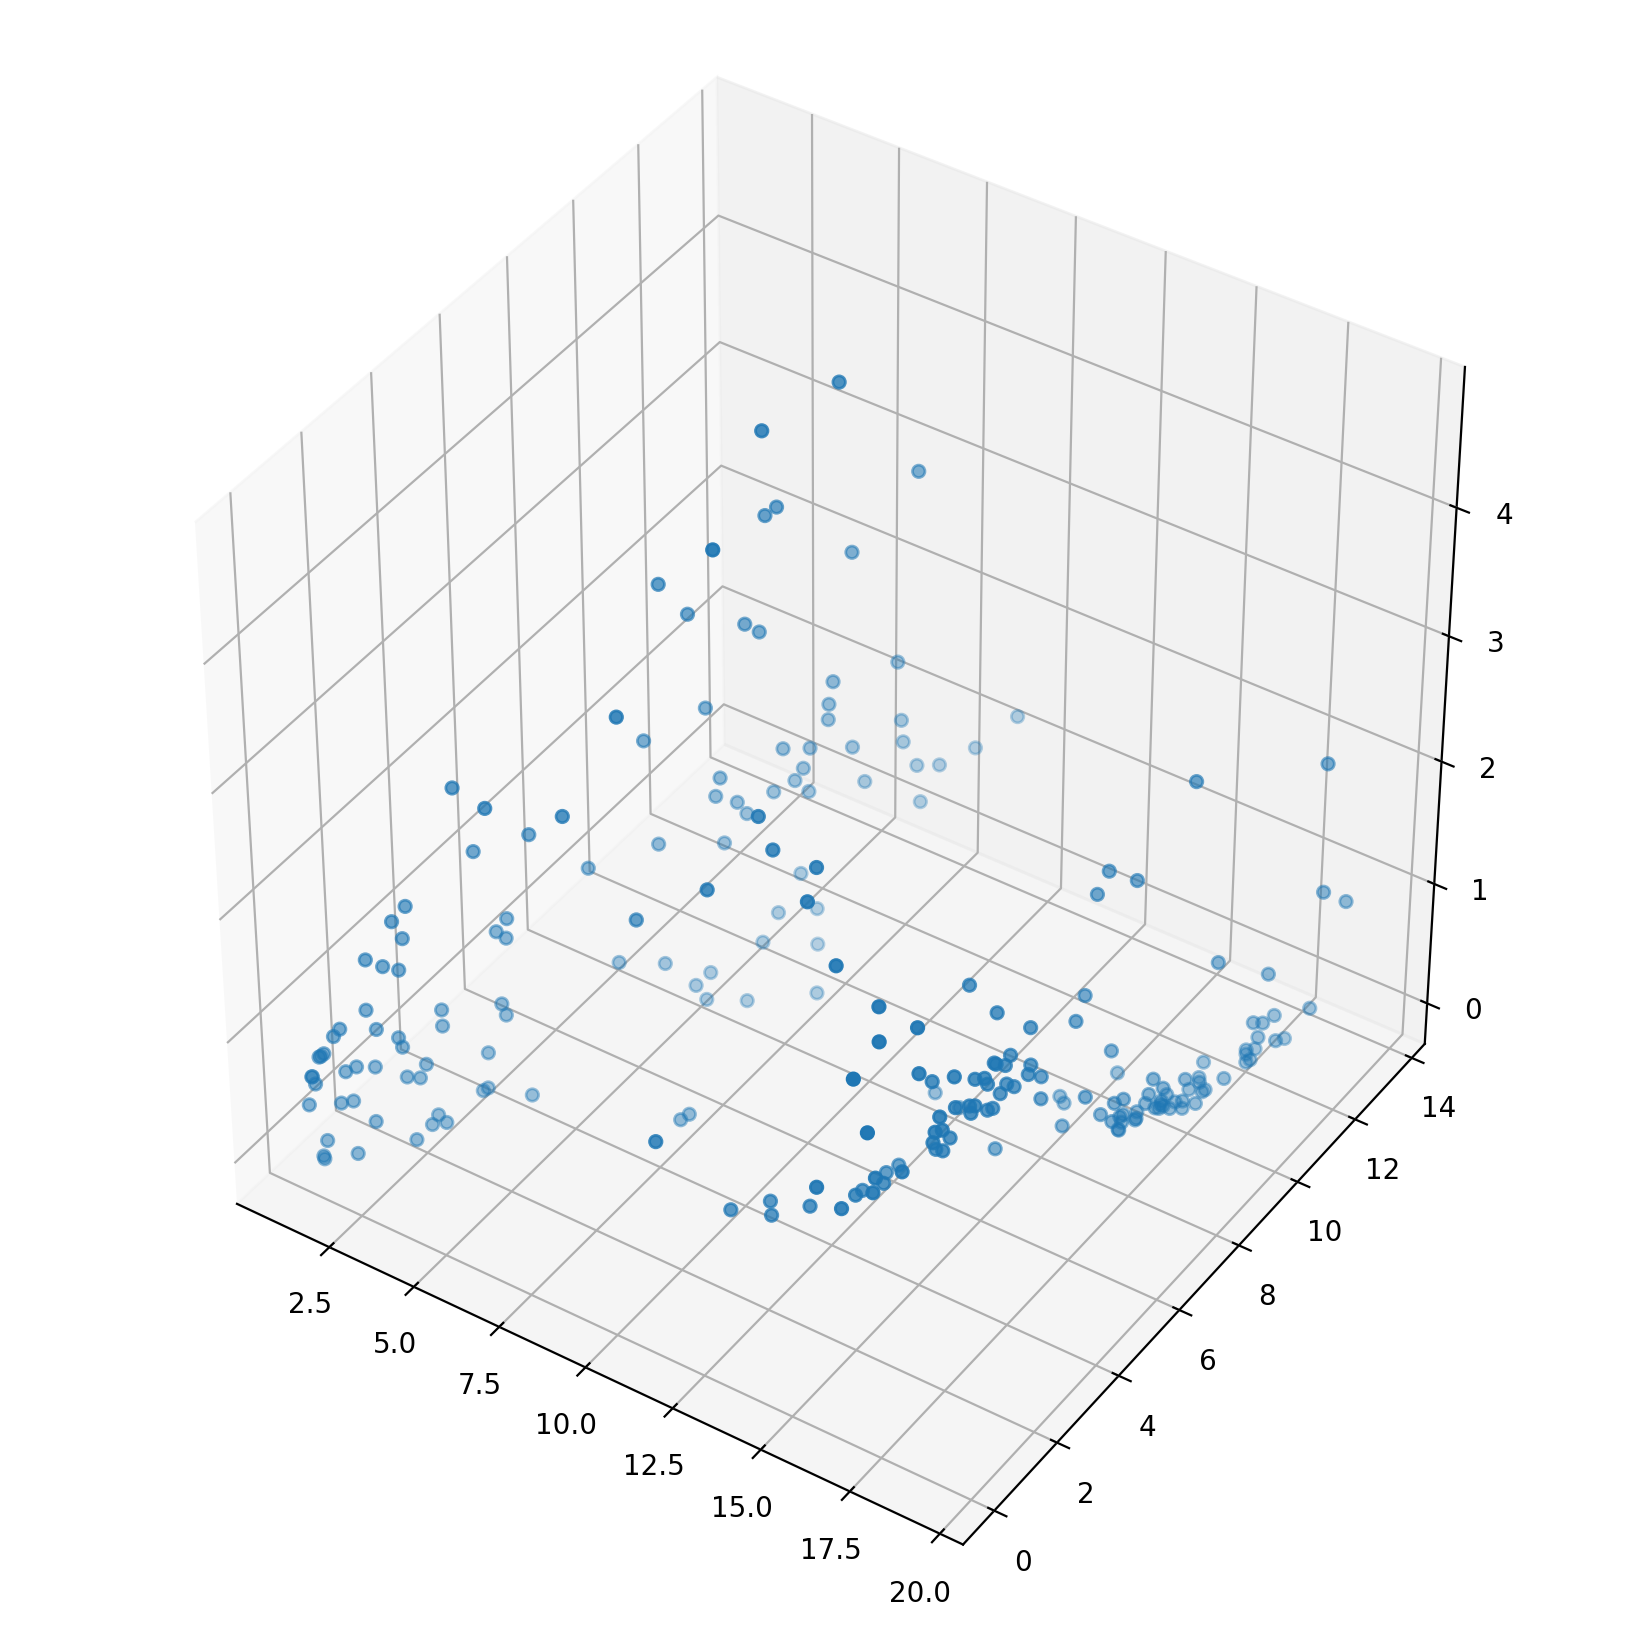

In [12]:
z_param = encoderZ3.predict(x_test)
#print(z_param)

fig = plt.figure(figsize=1.7*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(z_param[:,0],z_param[:,1],z_param[:,2])

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


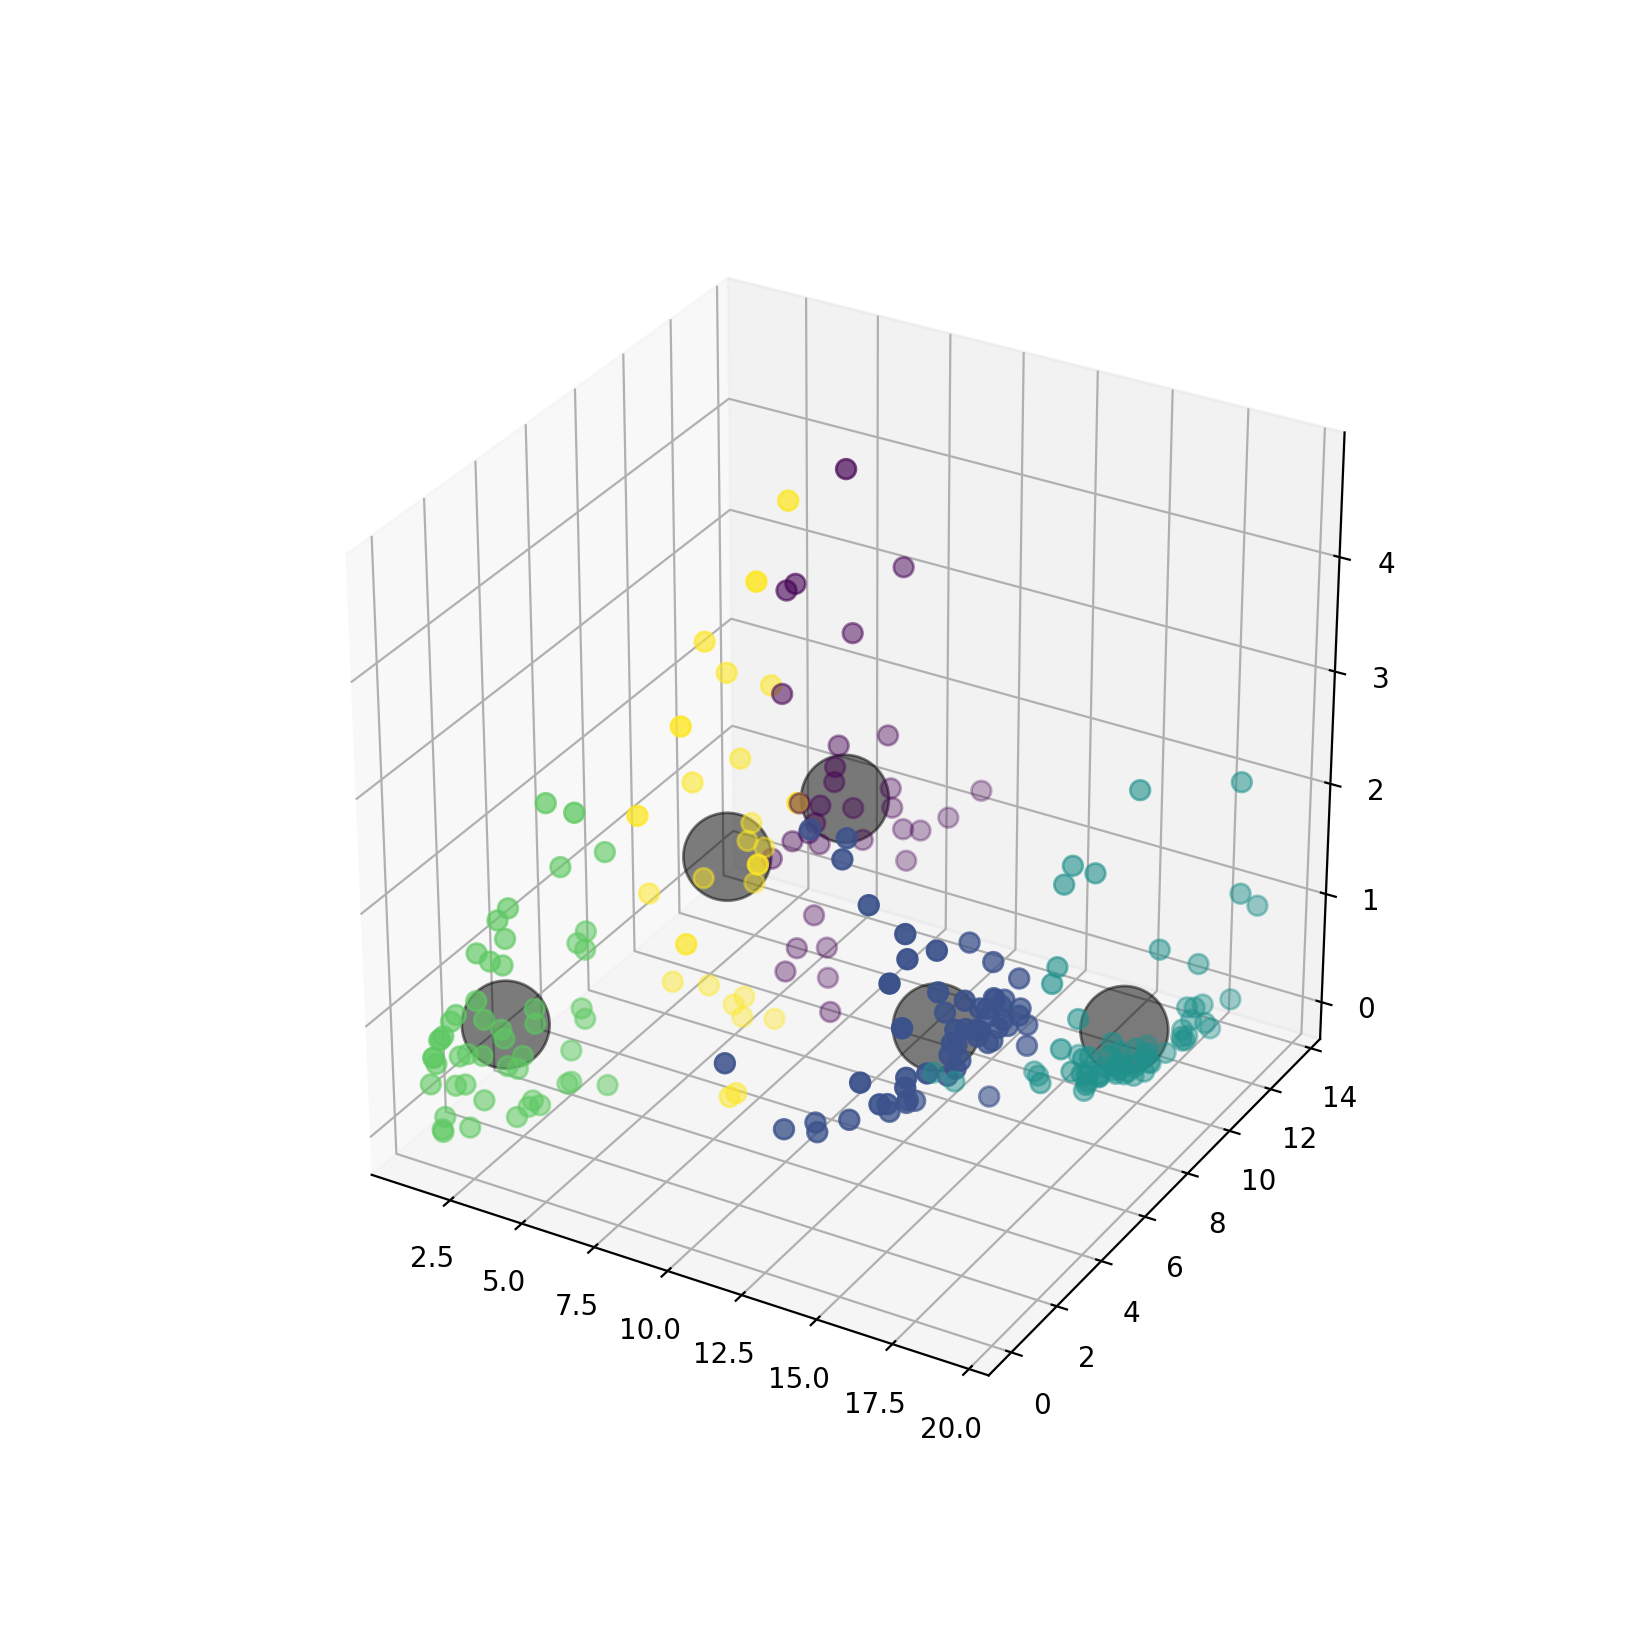

In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(z_param)
y_kmeans = kmeans.predict(z_param)

centers = kmeans.cluster_centers_
fig = plt.figure(figsize=1.7*plt.figaspect(1))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(z_param[:, 0], z_param[:, 1], z_param[:, 2], c=y_kmeans, s=50, cmap='viridis')
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', s=1000, alpha=0.5);

# Find similar paths using KNN on Cluster Centers